In [1]:
import time
import numpy as np
from numba import typed
from pruning.timeseries import SignalConfig, TimeSeries
from pruning.base import SearchConfig
from pruning.periodogram import Periodogram
from pruning import utils, ffa, scores, simulate, kernels
from matplotlib import pyplot as plt

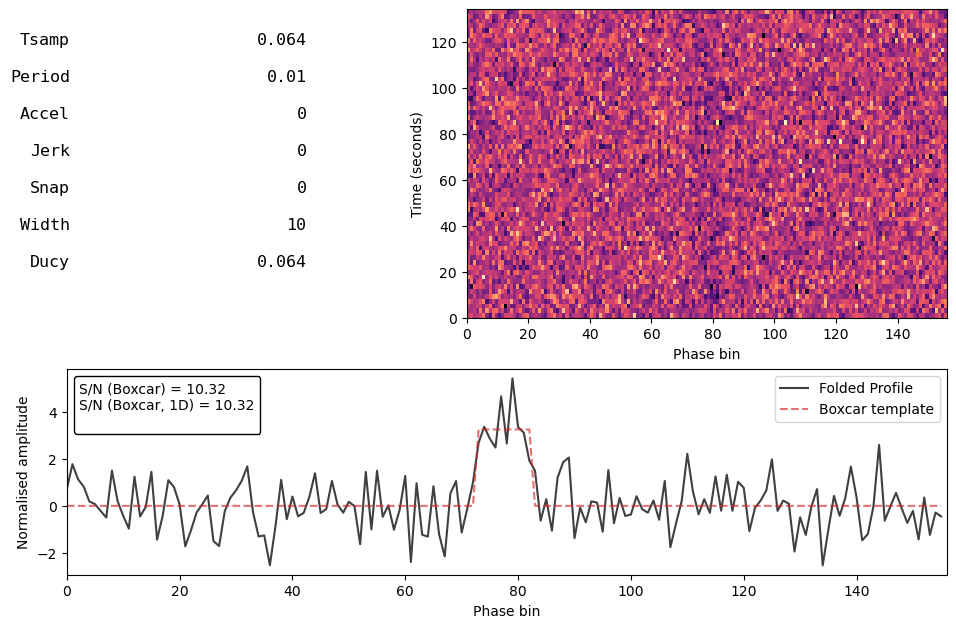

In [7]:
pulsar_period = 0.010  # (s)
dt = 6.4e-5
cfg = SignalConfig(period=pulsar_period, dt=dt, snr=10, ducy=0.1, nsamps=2**21, over_sampling=1)
tim_data = TimeSeries.generate_signal(cfg, shape="gaussian")
tim_data.plot_fold(cfg.freq, cfg.fold_bins); plt.show()

In [8]:
tol_bins = cfg.tol_bins
fold_bins = cfg.fold_bins

tol_bins = 1
param_limits = typed.List([(1/0.012, 1/0.007)])
search_cfg = SearchConfig(cfg.nsamps, cfg.dt, fold_bins, tol_bins, param_limits)
dyp = ffa.DynamicProgramming(tim_data, search_cfg)
dyp.initialize()
dyp.execute()

2024-07-28 09:08:36 INFO     - pruning.ffa - Initializing data structure...

                    INFO     - pruning.ffa - param steps: [0.6831049]

2024-07-28 09:08:37 INFO     - pruning.ffa - fold dimensions: (8192, 87, 2, 156)

                    INFO     - pruning.ffa - Initialization time: 0.33025407791137695

                    INFO     - pruning.ffa - param steps: [0.2487681]

                    INFO     - pruning.ffa - iteration: 1, fold dimensions: (4096, 239, 2, 156)

                    INFO     - pruning.ffa - param steps: [0.10950964]

                    INFO     - pruning.ffa - iteration: 2, fold dimensions: (2048, 543, 2, 156)

                    INFO     - pruning.ffa - param steps: [0.05166562]

2024-07-28 09:08:38 INFO     - pruning.ffa - iteration: 3, fold dimensions: (1024, 1152, 2, 156)

                    INFO     - pruning.ffa - param steps: [0.02512407]

                    INFO     - pruning.ffa - iteration: 4, fold dimensions: (512, 2369, 2, 156)

                    INFO     - pruning.ffa - param steps: [0.01239205]

                    INFO     - pruning.ffa - iteration: 5, fold dimensions: (256, 4803, 2, 156)

                    INFO     - pruning.ffa - param steps: [0.00615438]

                    INFO     - pruning.ffa - iteration: 6, fold dimensions: (128, 9671, 2, 156)

                    INFO     - pruning.ffa - param steps: [0.00306689]

                    INFO     - pruning.ffa - iteration: 7, fold dimensions: (64, 19408, 2, 156)

                    INFO     - pruning.ffa - param steps: [0.00153088]

2024-07-28 09:08:39 INFO     - pruning.ffa - iteration: 8, fold dimensions: (32, 38882, 2, 156)

                    INFO     - pruning.ffa - param steps: [0.0007648]

                    INFO     - pruning.ffa - iteration: 9, fold dimensions: (16, 77829, 2, 156)

                    INFO     - pruning.ffa - param steps: [0.00038224]

                    INFO     - pruning.ffa - iteration: 10, fold dimensions: (8, 155723, 2, 156)

                    INFO     - pruning.ffa - param steps: [0.00019108]

                    INFO     - pruning.ffa - iteration: 11, fold dimensions: (4, 311511, 2, 156)

                    INFO     - pruning.ffa - param steps: [9.55302286e-05]

2024-07-28 09:08:40 INFO     - pruning.ffa - iteration: 12, fold dimensions: (2, 623088, 2, 156)

                    INFO     - pruning.ffa - param steps: [4.7762623e-05]

2024-07-28 09:08:41 INFO     - pruning.ffa - iteration: 13, fold dimensions: (1, 1246242, 2, 156)

In [9]:
folds = dyp.get_fold_norm()
widths = scores.generate_width_trials(dyp.nbins, ducy_max=0.5, wtsp=1)
snrs = scores.boxcar_snr(folds, widths)
periods = dyp.param_arr[-1]

In [10]:
best_iperiod, best_iwidth = np.unravel_index(np.nanargmax(snrs), snrs.shape)
print(np.unravel_index(np.nanargmax(snrs), snrs.shape))
print(f"Best period = {1/periods[best_iperiod]}")
print(f"Best width = {widths[best_iwidth]}")
print(f"Best S/N = {np.nanmax(snrs)}")
print(f"expected width = {cfg.ducy * cfg.period / cfg.dt / cfg.fold_bins}")

(np.int64(348945), np.int64(9))
Best period = 0.010000009743580486
Best width = 10
Best S/N = 10.726195335388184
expected width = 0.10016025641025642


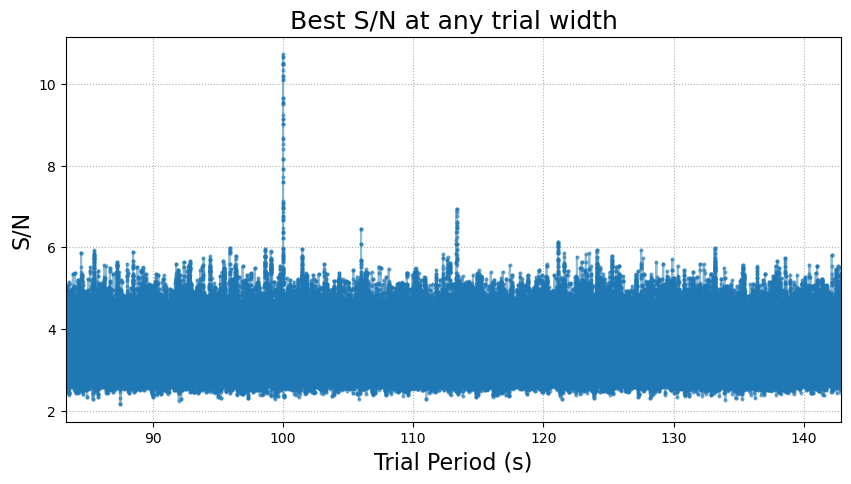

In [11]:
from pruning.periodogram import Periodogram
pgram = Periodogram(widths, periods, snrs, tim_data.tobs)
pgram.plot(figsize=(10, 5)); plt.show()